In [1]:
from collections import Counter, defaultdict
from itertools import combinations, chain, product
from matplotlib import pyplot as plt
import microhapdb
import networkx as nx
import pandas as pd
import random
import sys
import time
from tqdm.notebook import tqdm

In [2]:
markers = microhapdb.Marker.objectify(microhapdb.markers)
markers = [m for m in markers if "LV" not in m.name]
header = [
    "bin", "swScore", "milliDiv", "milliDel", "milliIns", "genoName", "genoStart", "genoEnd", "genoLeft",
    "strand", "repName", "repClass", "repFamily", "repStart", "repEnd", "repLeft", "id"
]
rmsk = pd.read_csv("rmsk.txt.gz", sep="\t", names=header)

In [3]:
def build_graphs(markers):
    graphs = defaultdict(nx.Graph)
    chroms = sorted(set([m.chrom for m in markers]))
    for chrom in chroms:
        cmarkers = [m for m in markers if m.chrom == chrom]
        graphs[chrom].add_nodes_from(cmarkers)
        for mh1, mh2 in combinations(cmarkers, 2):
            if abs(mh1.start - mh2.start) >= 10e6:
                graphs[chrom].add_edge(mh1, mh2)
    return graphs

In [4]:
def get_n_non_repetitive(markers, n=12):
    count = 0
    for mh in markers:
        overlap = rmsk[(rmsk.genoName == mh.chrom) & (rmsk.genoEnd > mh.start) & (rmsk.genoStart < mh.end)]
        if len(overlap) == 0:
            yield mh
            count += 1
            if count >= n:
                return

In [5]:
def build_light_graphs(markers):
    graphs = defaultdict(nx.Graph)
    chroms = sorted(set([m.chrom for m in markers]))
    for chrom in tqdm(chroms):
        cmarkers = [m for m in markers if m.chrom == chrom]
        short = [m for m in cmarkers if len(m) < 100 and m.data.Ae >= 3.0]
        medium = [m for m in cmarkers if 100 <= len(m) < 200 and m.data.Ae >= 4.5]
        long = [m for m in cmarkers if 200 <= len(m) < 300 and m.data.Ae >= 5.0]
        for marker_set in (short, medium, long):
            marker_set = sorted(marker_set, key=lambda m: m.data.Ae, reverse=True)
            marker_set = get_n_non_repetitive(marker_set, n=12)
            graphs[chrom].add_nodes_from(marker_set)
        for mh1, mh2 in combinations(graphs[chrom].nodes, 2):
            if abs(mh1.start - mh2.start) >= 10e6:
                graphs[chrom].add_edge(mh1, mh2)
    return graphs

In [6]:
graphs = build_light_graphs(markers)

  0%|          | 0/23 [00:00<?, ?it/s]

In [7]:
for chrom, graph in graphs.items():
    print(f"{chrom:>5s}: nodes={graph.number_of_nodes():<3d} edges={graph.number_of_edges()}")

 chr1: nodes=36  edges=499
chr10: nodes=25  edges=245
chr11: nodes=33  edges=412
chr12: nodes=30  edges=369
chr13: nodes=36  edges=483
chr14: nodes=21  edges=151
chr15: nodes=24  edges=215
chr16: nodes=30  edges=259
chr17: nodes=24  edges=204
chr18: nodes=16  edges=95
chr19: nodes=17  edges=100
 chr2: nodes=36  edges=569
chr20: nodes=13  edges=56
chr21: nodes=20  edges=95
chr22: nodes=13  edges=45
 chr3: nodes=29  edges=356
 chr4: nodes=36  edges=573
 chr5: nodes=34  edges=484
 chr6: nodes=29  edges=359
 chr7: nodes=32  edges=421
 chr8: nodes=32  edges=412
 chr9: nodes=35  edges=452
 chrX: nodes=3   edges=3


In [8]:
cliques_by_chrom = dict()
clique_distr_by_chrom = dict()
for chrom, graph in tqdm(sorted(graphs.items(), key=lambda cg: cg[1].number_of_edges())):
    #seed = chrom_seeds[chrom]
    #if seed is not None:
    #    seed = list(seed)
    cliques = list(nx.find_cliques(graph, nodes=None))
    cliques_by_chrom[chrom] = cliques
    clique_distr_by_chrom[chrom] = Counter([len(c) for c in cliques])

  0%|          | 0/23 [00:00<?, ?it/s]

In [9]:
for chrom, dist in sorted(clique_distr_by_chrom.items()):
    print(f"{chrom:6s} ", end="")
    print(*dist.most_common())

chr1   (8, 2340) (7, 1456) (9, 936) (6, 260)
chr10  (8, 1008) (7, 72)
chr11  (7, 3312) (6, 2376) (8, 192)
chr12  (8, 2304) (7, 1296)
chr13  (6, 5800) (5, 2975) (7, 1200)
chr14  (5, 248) (4, 124)
chr15  (6, 672) (5, 70)
chr16  (3, 260) (4, 250) (5, 60)
chr17  (5, 306) (4, 270) (6, 72)
chr18  (5, 90) (4, 81)
chr19  (4, 144)
chr2   (11, 46656) (10, 15552)
chr20  (4, 48) (3, 4)
chr21  (3, 76) (2, 11)
chr22  (3, 36) (2, 6)
chr3   (9, 2430) (10, 1620) (11, 270)
chr4   (11, 25600) (10, 18400) (12, 9600) (9, 2400)
chr5   (9, 7280) (10, 800) (8, 720)
chr6   (9, 1800) (10, 1800)
chr7   (9, 1792) (10, 742) (8, 415) (11, 36) (7, 25)
chr8   (8, 3300) (7, 1800) (9, 1200)
chr9   (5, 2256) (6, 1408) (4, 620)
chrX   (3, 1)


In [10]:
def has_short_medium_long(clique, mincount=1):
    short_count, medium_count, long_count = 0, 0, 0
    for marker in clique:
        mlen = len(marker)
        if mlen < 100:
            short_count += 1
        elif 100 <= mlen < 200:
            medium_count += 1
        elif 200 <= mlen < 300:
            long_count += 1
        if short_count >= mincount and medium_count >= mincount and long_count >= mincount:
            return True
    return False

In [11]:
helpful_cliques_2 = defaultdict(list)
helpful_cliques_1 = defaultdict(list)
for chrom, cliques in tqdm(cliques_by_chrom.items()):
    for clique in cliques:
        if has_short_medium_long(clique, mincount=2):
            helpful_cliques_2[chrom].append(clique)
    if len(helpful_cliques_2[chrom]) == 0:
        for clique in cliques:
            if has_short_medium_long(clique, mincount=1):
                helpful_cliques_1[chrom].append(clique)
    len2 = len(helpful_cliques_2[chrom])
    len1 = len(helpful_cliques_1[chrom])
    print(f"{chrom:6s} {len2:5} {len1:5}")

  0%|          | 0/23 [00:00<?, ?it/s]

chrX       0     0
chr22      0     3
chr20      0    20
chr18      0    30
chr21      0    19
chr19      0    26
chr14      0    78
chr17     12     0
chr15     51     0
chr10    483     0
chr16      0   177
chr3    1803     0
chr6    2721     0
chr12   1672     0
chr11   1312     0
chr8    2008     0
chr7    1842     0
chr9     205     0
chr13   1224     0
chr5    5404     0
chr1    1660     0
chr2   55908     0
chr4   45540     0


In [12]:
def clique_avg_ae(clique):
    return sum(marker.data.Ae for marker in clique) / len(clique)

In [13]:
def clique_repr(clique, n):
    short = [mh for mh in clique if len(mh) < 100]
    medium = [mh for mh in clique if 100 <= len(mh) < 200]
    long = [mh for mh in clique if 200 <= len(mh) < 300]
    short = sorted(short, key=lambda mh: mh.data.Ae, reverse=True)
    medium = sorted(medium, key=lambda mh: mh.data.Ae, reverse=True)
    long = sorted(long, key=lambda mh: mh.data.Ae, reverse=True)
    return [*short[:n], *medium[:n], *long[:n]]

In [14]:
keepers = dict()
for chrom in tqdm(cliques_by_chrom):
    if len(helpful_cliques_2[chrom]) == 0 and len(helpful_cliques_1[chrom]) == 0:
        continue
    if len(helpful_cliques_2[chrom]) > 0:
        cliques = helpful_cliques_2[chrom]
        n = 2
    else:
        cliques = helpful_cliques_1[chrom]
        n = 1
    best_avg_ae = 0.0
    best_clique = None
    for clique in cliques:
        clique = clique_repr(clique, n=n)
        avg_ae = clique_avg_ae(clique)
        if avg_ae > best_avg_ae:
            best_avg_ae = avg_ae
            best_clique = clique
    keepers[chrom] = best_clique

  0%|          | 0/23 [00:00<?, ?it/s]

In [15]:
for chrom, clique in keepers.items():
    print(chrom, *[mh.name for mh in clique])

chr22 mh22NH-27 mh22WL-005.v1 mh22WL-004.v2
chr20 mh20WL-026.v2 mh20WL-023.v1 mh20WL-022.v2
chr18 mh18WL-018 mh18WL-014 mh18WL-020
chr21 mh21USC-21qA mh21KK-324.v2 mh21WL-020.v2
chr19 mh19USC-19qB.v3 mh19USC-19qA.v2 mh19SHY-001.v3
chr14 mh14WL-028.v2 mh14SCUZJ-0008955 mh14SHY-003.v3
chr17 mh17USC-17qB mh17CP-002 mh17WL-011.v1 mh17WL-004.v1 mh17WL-022.v1 mh17WL-032
chr15 mh15WL-015.v2 mh15WL-042 mh15WL-034 mh15WL-004.v1 mh15WL-001.v4 mh15WL-031.v2
chr10 mh10WL-042 mh10WL-028 mh10WL-049 mh10SCUZJ-0082020 mh10WL-031 mh10WL-022.v2
chr16 mh16KK-259.v6 mh16WL-012.v1 mh16WL-030
chr3 mh03USC-3qC.v1 mh03LW-11 mh03FHL-003.v1 mh03WL-003 mh03FHL-001.v2 mh03SCUZJ-0388069
chr6 mh06WL-041 mh06WL-063.v2 mh06WL-017.v1 mh06WL-008.v1 mh06WL-051 mh06KK-008.v3
chr12 mh12USC-12qC mh12USC-12qA mh12KK-201.v2 mh12SHY-001.v2 mh12WL-002.v2 mh12SCUZJ-0392651
chr11 mh11PK-63643.v1 mh11WL-026 mh11WL-003.v1 mh11WL-005.v1 mh11KK-180.v2 mh11WL-036
chr8 mh08WL-030 mh08SCUZJ-0523897 mh08WL-058.v1 mh08WL-023 mh08WL-037 m

In [16]:
sum([len(clique) for clique in keepers.values()])

111

In [17]:
panel = list()
for clique in keepers.values():
    panel.extend(clique)
panel_short = [mh for mh in panel if len(mh) < 100]
panel_medium = [mh for mh in panel if 100 <= len(mh) < 200]
panel_long = [mh for mh in panel if 200 <= len(mh) < 300]
print(len(panel_short), len(panel_medium), len(panel_long))

37 37 37


In [18]:
print(*[mh.name for mh in panel])

mh22NH-27 mh22WL-005.v1 mh22WL-004.v2 mh20WL-026.v2 mh20WL-023.v1 mh20WL-022.v2 mh18WL-018 mh18WL-014 mh18WL-020 mh21USC-21qA mh21KK-324.v2 mh21WL-020.v2 mh19USC-19qB.v3 mh19USC-19qA.v2 mh19SHY-001.v3 mh14WL-028.v2 mh14SCUZJ-0008955 mh14SHY-003.v3 mh17USC-17qB mh17CP-002 mh17WL-011.v1 mh17WL-004.v1 mh17WL-022.v1 mh17WL-032 mh15WL-015.v2 mh15WL-042 mh15WL-034 mh15WL-004.v1 mh15WL-001.v4 mh15WL-031.v2 mh10WL-042 mh10WL-028 mh10WL-049 mh10SCUZJ-0082020 mh10WL-031 mh10WL-022.v2 mh16KK-259.v6 mh16WL-012.v1 mh16WL-030 mh03USC-3qC.v1 mh03LW-11 mh03FHL-003.v1 mh03WL-003 mh03FHL-001.v2 mh03SCUZJ-0388069 mh06WL-041 mh06WL-063.v2 mh06WL-017.v1 mh06WL-008.v1 mh06WL-051 mh06KK-008.v3 mh12USC-12qC mh12USC-12qA mh12KK-201.v2 mh12SHY-001.v2 mh12WL-002.v2 mh12SCUZJ-0392651 mh11PK-63643.v1 mh11WL-026 mh11WL-003.v1 mh11WL-005.v1 mh11KK-180.v2 mh11WL-036 mh08WL-030 mh08SCUZJ-0523897 mh08WL-058.v1 mh08WL-023 mh08WL-037 mh08WL-056.v2 mh07WL-067 mh07USC-7qA mh07WL-004.v1 mh07SCUZJ-0380111.v2 mh07SCUZJ-050229

In [19]:
source_counts = Counter()
for mh in panel:
    for source in mh.data.Source.split(";"):
        source_counts[source] += 1
print(*source_counts.most_common(), sep="\n")

('Yu2022G3', 38)
('Yu2022G1', 37)
('Yu2022G2', 23)
('Zhu2023', 19)
('Yu2022G4', 17)
('delaPuente2020', 11)
('Gandotra2020', 2)
('Zhang2023', 2)
('Pakstis2021', 2)
('NimaGen2023', 2)
('Hiroaki2015', 1)
('Chen2019', 1)
('Fan2022', 1)
('vanderGaag2018', 1)
('Du2023', 1)
('Kidd2018', 1)
('Turchi2019', 1)
('Staadig2021', 1)
('Wu2021', 1)


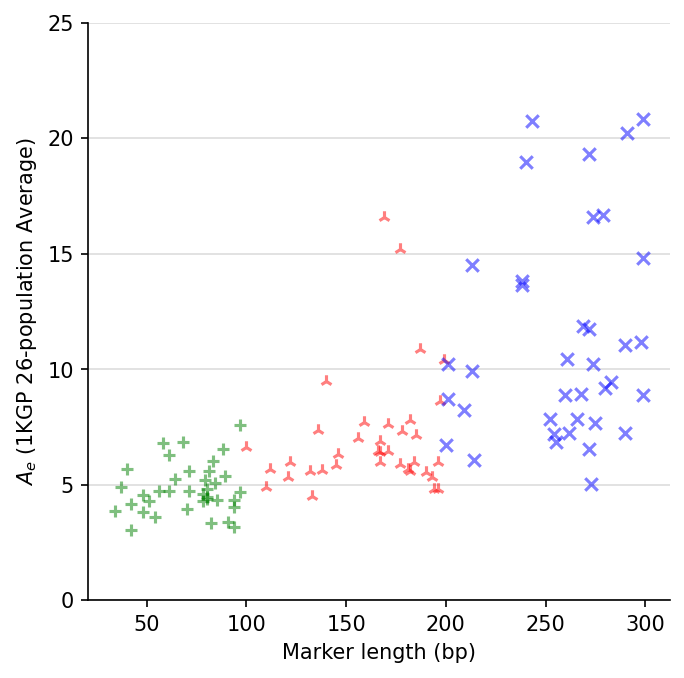

In [20]:
plt.figure(figsize=(5, 5), dpi=150)
plt.scatter([len(mh) for mh in panel_short], [mh.data.Ae for mh in panel_short], marker="+", alpha=0.5, color="green")
plt.scatter([len(mh) for mh in panel_medium], [mh.data.Ae for mh in panel_medium], marker="2", alpha=0.5, color="red")
plt.scatter([len(mh) for mh in panel_long], [mh.data.Ae for mh in panel_long], marker="x", alpha=0.5, color="blue")
plt.ylabel("$A_e$ (1KGP 26-population Average)")
plt.xlabel("Marker length (bp)")
plt.ylim((0, 25))
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().yaxis.grid(True, color="#DDDDDD")
plt.gca().set_axisbelow(True)

In [30]:
microhapdb.markers[(microhapdb.markers.Name.isin([mh.name for mh in panel if mh.data.Ae < 5])) & (microhapdb.markers.Extent >= 100)]

,Name,NumVars,Extent,Chrom,Start,End,Positions,Positions37,RSIDs,Source,Ae
2649,mh17WL-004.v1,4,194,chr17,68793693,68793886,68793693;68793818;68793847;68793886,66789834;66789959;66789988;66790027,rs16967221;rs2120192;rs6501742;rs9891808,Yu2022G1;Yu2022G2,4.790
2793,mh19SCUZJ-0056108,6,214,chr19,11146421,11146634,11146421;11146493;11146532;11146561;11146581;1...,11257097;11257169;11257208;11257237;11257257;1...,NaN,Zhu2023,3.835
2843,mh19WL-012,11,195,chr19,57013159,57013353,57013159;57013183;57013194;57013204;57013260;5...,57524527;57524551;57524562;57524572;57524628;5...,rs146339596;rs35575124;rs35524414;rs78154033;r...,Yu2022G1;Yu2022G2,4.385
3037,mh22WL-005.v1,6,133,chr22,49407294,49407426,49407294;49407371;49407377;49407382;49407404;4...,49800943;49801020;49801026;49801031;49801053;4...,rs470069;rs13057659;rs151257601;rs62235263;rs1...,Yu2022G1;Yu2022G2;Yu2022G3,4.523


In [32]:
microhapdb.markers[microhapdb.markers.Name.isin([mh.name for mh in panel if mh.data.Ae > 40])]

,Name,NumVars,Extent,Chrom,Start,End,Positions,Positions37,RSIDs,Source,Ae
237,mh01SCUZJ-0675568,15,248,chr1,246868891,246869138,246868891;246868905;246868927;246868930;246868...,247032193;247032207;247032229;247032232;247032...,NaN,Zhu2023,72.533


In [35]:
header = ["bin", "swScore", "milliDiv", "milliDel", "milliIns", "genoName", "genoStart", "genoEnd", "genoLeft", "strand", "repName", "repClass", "repFamily", "repStart", "repEnd", "repLeft", "id"]
rmsk = pd.read_csv("rmsk.txt.gz", sep="\t", names=header)
rmsk.head()

,bin,swScore,milliDiv,milliDel,milliIns,genoName,genoStart,genoEnd,genoLeft,strand,repName,repClass,repFamily,repStart,repEnd,repLeft,id
0,585,463,13,6,17,chr1,10000,10468,-248945954,+,(TAACCC)n,Simple_repeat,Simple_repeat,1,471,0,1
1,585,3612,114,215,13,chr1,10468,11447,-248944975,-,TAR1,Satellite,telo,-399,1712,483,2
2,585,484,251,132,0,chr1,11504,11675,-248944747,-,L1MC5a,LINE,L1,-2382,395,199,3
3,585,239,294,19,10,chr1,11677,11780,-248944642,-,MER5B,DNA,hAT-Charlie,-74,104,1,4
4,585,318,230,37,0,chr1,15264,15355,-248941067,-,MIR3,SINE,MIR,-119,143,49,5


In [43]:
repeats = dict()
for marker in panel:
    overlap = rmsk[(rmsk.genoName == marker.chrom) & (rmsk.genoEnd > marker.start) & (rmsk.genoStart < marker.end)]
    rep = len(overlap) > 0
    if rep:
        repeats[marker.name] = overlap
print(len(repeats))

61


In [45]:
sample = random.sample(repeats.keys(), 5)
print(*sample)

mh22SCUZJ-0043764 mh14SCUZJ-0096560 mh05WL-004 mh02LW-7 mh12SCUZJ-0364164


/var/folders/c_/5x4wpqxd73923hskscprwxg1j8qmlk/T/ipykernel_3014/412080204.py:1: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(repeats.keys(), 5)


In [51]:
repeats["mh05WL-004"]

,bin,swScore,milliDiv,milliDel,milliIns,genoName,genoStart,genoEnd,genoLeft,strand,repName,repClass,repFamily,repStart,repEnd,repLeft,id
3883207,1187,287,321,131,22,chr5,78976854,78977161,-102561098,+,L2a,LINE,L2,2916,3254,-121,3


In [21]:
print(*[mh.name for mh in panel])

mh22LS-22qB mh22WL-005.v1 mh22SCUZJ-0043764 mh21KK-324.v4 mh21FHL-002.v1 mh21SCUZJ-0002749 mh16WL-040.v1 mh16WL-012.v1 mh16KK-259.v3 mh20SCUZJ-0148996 mh20WL-023.v1 mh20SCUZJ-0014987 mh19WL-018 mh19KK-299.v4 mh19USC-19qA.v2 mh19WL-012 mh19SCUZJ-0007484 mh19SCUZJ-0056108 mh14WL-028.v2 mh14LW-35 mh14SCUZJ-0040957.v1 mh14SCUZJ-0096560 mh14SHY-003.v3 mh14WL-030.v2 mh17USC-17qB mh17CP-005 mh17KK-278.v1 mh17WL-004.v1 mh17WL-022.v1 mh17SCUZJ-0017214.v1 mh11PK-63643.v1 mh11WL-026 mh11WL-004.v1 mh11WL-005.v1 mh11SCUZJ-0402779 mh11SCUZJ-0078959 mh18WL-031 mh18WL-018 mh18WL-022.v1 mh18SHY-001 mh18SCUZJ-0236206 mh18SCUZJ-0058695 mh13KK-225.v2 mh13LW-33 mh13KK-218.v4 mh13SCUZJ-0323513 mh13WL-001.v2 mh13USC-13qA.v3 mh09USC-9qC mh09USC-9qA mh09SCUZJ-0076471 mh09WL-034 mh09SHY-001.v3 mh09KK-153.v3 mh15USC-15qA mh15LW-39 mh15SCUZJ-0082880 mh15WL-001.v1 mh15SCUZJ-0267777 mh15SCUZJ-0204760.v1 mh10SHY-002.v2 mh10SCUZJ-0204710.v2 mh10WL-012.v1 mh10WL-001.v1 mh10SCUZJ-0255190 mh10SCUZJ-0149820 mh01WL-087 mh

In [22]:
source_counts = Counter()
for mh in panel:
    for source in mh.data.Source.split(";"):
        source_counts[source] += 1
print(*source_counts.most_common(), sep="\n")

('Zhu2023', 45)
('Yu2022G1', 28)
('Yu2022G3', 20)
('Yu2022G2', 19)
('Yu2022G4', 13)
('Zhang2023', 8)
('delaPuente2020', 6)
('Pakstis2021', 4)
('Staadig2021', 3)
('Fan2022', 3)
('Gandotra2020', 3)
('Wu2021', 3)
('NimaGen2023', 2)
('Du2023', 1)
('Kidd2018', 1)
('vanderGaag2018', 1)


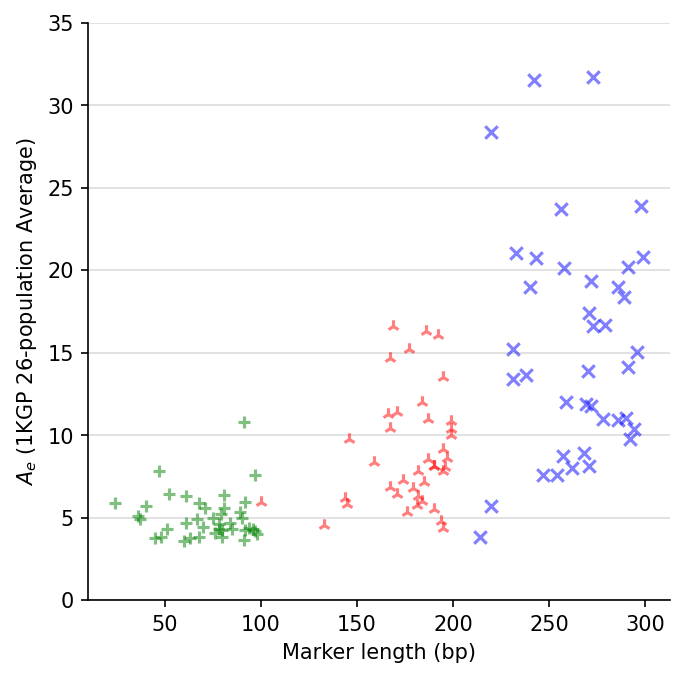

In [31]:
plt.figure(figsize=(5, 5), dpi=150)
plt.scatter([len(mh) for mh in panel_short], [mh.data.Ae for mh in panel_short], marker="+", alpha=0.5, color="green")
plt.scatter([len(mh) for mh in panel_medium], [mh.data.Ae for mh in panel_medium], marker="2", alpha=0.5, color="red")
plt.scatter([len(mh) for mh in panel_long], [mh.data.Ae for mh in panel_long], marker="x", alpha=0.5, color="blue")
plt.ylabel("$A_e$ (1KGP 26-population Average)")
plt.xlabel("Marker length (bp)")
plt.ylim((0, 35))
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().yaxis.grid(True, color="#DDDDDD")
plt.gca().set_axisbelow(True)

In [3]:
def clique_distr_per_chromosome(cmarkers):
    cgraph = nx.Graph()
    cgraph.add_nodes_from(cmarkers)
    for mh1, mh2 in combinations(cmarkers, 2):
        if abs(mh1.start - mh2.start) >= 10e6:
            cgraph.add_edge(mh1, mh2)
    cliques = list(nx.find_cliques(cgraph))
    clique_size_distr = Counter([len(c) for c in cliques])
    return cliques, clique_size_distr

In [ ]:
chroms = sorted(set([m.chrom for m in markers]))
cliques_by_chrom = dict()
clique_distr_by_chrom = dict()
for chrom in chroms:
    cmarkers = [m for m in markers if m.chrom == chrom]
    cliques, clique_size_distr = clique_distr_per_chromosome(cmarkers)
    cliques_by_chrom[chrom] = cliques
    clique_distr_by_chrom[chrom] = clique_size_dist
    print(f"{chrom} done!")

In [3]:
short = [m for m in markers if len(m) < 100]
medium = [m for m in markers if 100 <= len(m) < 200]
long = [m for m in markers if 200 <= len(m) < 300]
print(f"short N={len(short)} maxAe={max([m.data.Ae for m in short])}")
print(f"medium N={len(medium)} maxAe={max([m.data.Ae for m in medium])}")
print(f"long N={len(long)} maxAe={max([m.data.Ae for m in long])}")

short N=675 maxAe=10.818
medium N=1139 maxAe=16.593
long N=768 maxAe=72.533


In [27]:
graph = nx.Graph()
cmarkers = [m for m in markers if m.chrom == "chr19"]
graph.add_nodes_from(cmarkers)
for mh1, mh2 in combinations(cmarkers, 2):
    if abs(mh1.start - mh2.start) >= 10e6:
        graph.add_edge(mh1, mh2)

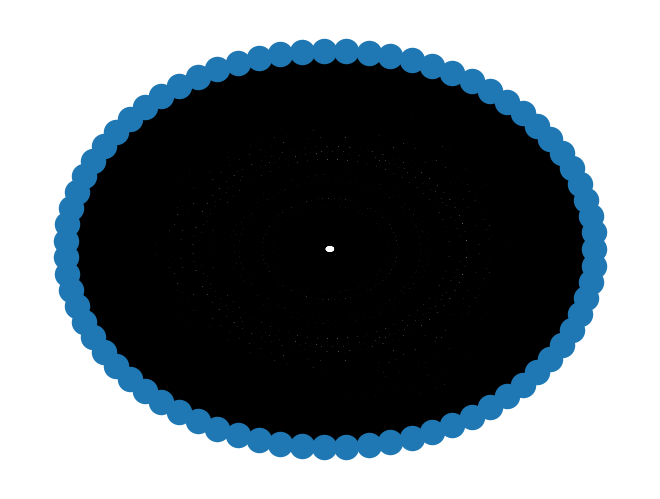

In [34]:
nx.draw_circular(graph)

In [29]:
gprime = max(nx.connected_components(graph), key=len)
print(len(graph), len(gprime))

75 75


In [31]:
cliques = list(nx.enumerate_all_cliques(graph))
len(cliques)

154508

In [79]:
max([len(c) for c in cliques])

6

In [80]:
max_cliques = [c for c in cliques if len(c) >= 5]
len(max_cliques)

48145

In [82]:
max_cliques_all_lengths = [c for c in max_cliques if has_short_medium_long(c)]
len(max_cliques_all_lengths)

25415

In [84]:
max_cliques_all_lengths_sorted = sorted(max_cliques_all_lengths, key=lambda c: clique_avg_ae(c), reverse=True)

In [85]:
[m.name for m in max_cliques_all_lengths_sorted[0]], clique_avg_ae(max_cliques_all_lengths_sorted[0])

(['mh19SCUZJ-0028962',
  'mh19SCUZJ-0091391',
  'mh19USC-19qA.v2',
  'mh19WL-018',
  'mh19SCUZJ-0249059.v1'],
 9.2618)

In [86]:
[m.name for m in max_cliques_all_lengths_sorted[1]], clique_avg_ae(max_cliques_all_lengths_sorted[1])

(['mh19SCUZJ-0028962',
  'mh19USC-19pB',
  'mh19SCUZJ-0121709',
  'mh19SCUZJ-0164190',
  'mh19SCUZJ-0249059.v1'],
 9.099599999999999)

In [87]:
[m.name for m in max_cliques_all_lengths_sorted[2]], clique_avg_ae(max_cliques_all_lengths_sorted[2])

(['mh19SCUZJ-0028962',
  'mh19USC-19pB',
  'mh19ZHA-007',
  'mh19SCUZJ-0164190',
  'mh19SCUZJ-0249059.v1'],
 9.0414)

In [ ]:
# generate cliques of different lengths for each chromosome; combine, rank, filter, and see which panel of 120 has the best avg Ae